# A filter for BAGAN_GP

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Dropout,Flatten,Dense,Input
from tensorflow.keras import Model

## Prepare the dataset

In [2]:
## Load raw data

seq_data=[]
label_data=[]
f_s_data=[]
seq_dict={ "T":[1,0,0,0],"C":[0,1,0,0],"A":[0,0,1,0],"G":[0,0,0,1]}
# inverse_seq_dict={ 0.25 : 'T', 0.5 : 'C', 0.75 : 'A', 1 : 'G'}
for cls in range(5):
    x_data=pd.read_csv("./seq_{cls}.csv".format(cls=cls+1),header=0)
    for idx,row in x_data.iterrows():
        sub_seq_list=[]
        sub_feature_list=[]
        for i in row[0]:
            sub_seq_list.append(seq_dict[i])
        for j in row[1:]:
            sub_feature_list.append(j)
        f_s_data.append((sub_seq_list,sub_feature_list))
        label_data.append(cls)

In [3]:
##  Proportionally split training data and test data

from sklearn.model_selection import train_test_split
SEED = 15
x_train, x_test, y_train, y_test = train_test_split(f_s_data, label_data,
                                                  random_state=SEED,
                                                  test_size=0.2,
                                                  stratify=label_data)
label_train=y_train
label_test=y_test
y_train=tf.one_hot(y_train, depth=5)
y_test=tf.one_hot(y_test,depth=5)

feature_data=[]
seq_data=[]
for i in x_train:
    feature_data.append(i[1])
    seq_data.append(i[0])
feature_data=np.array(feature_data)
seq_data=np.expand_dims(np.array(seq_data),-1)
x_train=(tf.convert_to_tensor(seq_data, dtype=tf.float32),tf.convert_to_tensor(feature_data, dtype=tf.float32))

feature_data=[]
seq_data=[]
for i in x_test:
    feature_data.append(i[1])
    seq_data.append(i[0])
feature_data=np.array(feature_data)
seq_data=np.expand_dims(np.array(seq_data),-1)
x_test=(tf.convert_to_tensor(seq_data, dtype=tf.float32),tf.convert_to_tensor(feature_data, dtype=tf.float32))

In [4]:
## The proportion of data by category
print("{count}".format(count=np.unique(label_train)))
for i in np.unique(label_train):
    print("{i}:{sum}".format(i=i,sum=np.sum(label_train==i)/len(label_train)))

[0 1 2 3 4]
0:0.5092165898617511
1:0.13895781637717122
2:0.1338177951081177
3:0.08454448777029422
4:0.13346331088266572


In [5]:
print("{count}".format(count=np.unique(label_test)))
for i in np.unique(label_test):
    print("{i}:{sum}".format(i=i,sum=np.sum(label_test==i)/len(label_test)))

[0 1 2 3 4]
0:0.5095676824946846
1:0.13890857547838412
2:0.1339475549255847
3:0.08433734939759036
4:0.1332388377037562


## Define and train the filter model

In [6]:
class Modforcls(Model):
    def __init__(self):
        super(Modforcls, self).__init__()
        
        self.c1 = Conv2D(128, (3, 3),padding='same',input_shape=(50, 4, 1),kernel_regularizer='l1')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        
        self.c2=Conv2D(128, (3, 3),padding='same', kernel_regularizer='l1')
        self.b2 = BatchNormalization()
        self.a2 = Activation('relu')
        
        self.c3 = Conv2D(64, (3, 3),padding='same', kernel_regularizer='l1')
        self.b3 = BatchNormalization()
        self.a3 = Activation('relu')
        
        self.flatten = Flatten()
        
        self.f1 = Dense(1024, activation='relu')
        self.df1 = Dropout(0.3)
        self.f2 = Dense(512,activation="relu")
        self.df2 = Dropout(0.3)
        
        self.ff1 = Dense(1024, activation='relu')
        self.dff1 = Dropout(0.3)
        self.ff2 = Dense(256, activation="relu")
        self.dff2 = Dropout(0.3)
        
        self.f3 = Dense(512 , activation="relu")
        self.df3 = Dropout(0.3)
        self.f4 = Dense(256,activation="relu")
        self.df4 = Dropout(0.3)
        self.f5 = Dense(5,activation="softmax")
    

    def call(self, x):
        x_1=x[0]
        x_2=x[1]
        x = self.c1(x_1)
        x = self.b1(x)
        x = self.a1(x)
        
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        
        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        
        x = self.flatten(x)
        x = self.f1(x)
        x = self.df1(x)
        x = self.f2(x)
        x = self.df2(x)
        
        y = self.ff1(x_2)
        y = self.dff1(y)
        y = self.ff2(y)
        y = self.dff2(y)
        
        out=tf.keras.layers.Concatenate(axis=-1)([x,y])
#         out=tf.keras.layers.add([x,y])
#         out = x
        out = self.f3(out)
        out = self.df3(out)
        out = self.f4(out)
        out = self.df4(out)
        out = self.f5(out)
        return out
    
    def model(self):
        x=Input(shape=(10,4,1))
        y=Input(shape=(5,))
        return Model(inputs=[(x,y)],outputs=self.call((x,y)))
    
    def weight_cross_entropy(self, y_true,y_pred):
    # 0.64281: [1.2, 2.2, 2.2, 3, 2.2]
        weight=tf.constant([[1.2, 2.2, 2.5, 3, 2.2]],dtype=tf.float32)
        loss=tf.reduce_sum(-tf.multiply(y_true,weight)*tf.math.log(y_pred+0.0001),axis=1)
        return loss
    
# tbcallback = TensorBoard(log_dir="./model/tensorboard", histogram_freq=1, write_grads=True)
cpktcallback = ModelCheckpoint("./model/cpkt/cls_weight",
                                 monitor="val_categorical_accuracy",
                                 mode='max',
                                 save_weights_only=True,
                                 save_best_only=True, 
                                 verbose=1,
                                 period=1)

model = Modforcls()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False),
              loss=model.weight_cross_entropy,
              metrics=['categorical_accuracy'])
model.fit(x_train, y_train, 
          batch_size=64, epochs=500, 
          validation_data=(x_test,y_test), 
          validation_freq=1, shuffle=True,
          callbacks=[cpktcallback])

Epoch 1/500
89/89 [==============================] - 10s 13ms/step - loss: 62.3122 - categorical_accuracy: 0.3166 - val_loss: 61.6439 - val_categorical_accuracy: 0.5096

Epoch 00001: val_categorical_accuracy improved from -inf to 0.50957, saving model to ./model/cpkt\cls_weight
Epoch 2/500
89/89 [==============================] - 1s 9ms/step - loss: 61.1624 - categorical_accuracy: 0.3924 - val_loss: 60.6004 - val_categorical_accuracy: 0.5096

Epoch 00002: val_categorical_accuracy did not improve from 0.50957
Epoch 3/500
89/89 [==============================] - 1s 9ms/step - loss: 60.1145 - categorical_accuracy: 0.4174 - val_loss: 59.5566 - val_categorical_accuracy: 0.5096

Epoch 00003: val_categorical_accuracy did not improve from 0.50957
Epoch 4/500
89/89 [==============================] - 1s 9ms/step - loss: 59.0363 - categorical_accuracy: 0.4272 - val_loss: 58.5165 - val_categorical_accuracy: 0.5096

Epoch 00004: val_categorical_accuracy did not improve from 0.50957
Epoch 5/500
89/8

89/89 [==============================] - 1s 9ms/step - loss: 35.8703 - categorical_accuracy: 0.5845 - val_loss: 35.5675 - val_categorical_accuracy: 0.6038

Epoch 00031: val_categorical_accuracy did not improve from 0.60666
Epoch 32/500
89/89 [==============================] - 1s 9ms/step - loss: 35.2804 - categorical_accuracy: 0.5877 - val_loss: 34.9814 - val_categorical_accuracy: 0.6045

Epoch 00032: val_categorical_accuracy did not improve from 0.60666
Epoch 33/500
89/89 [==============================] - 1s 9ms/step - loss: 34.7042 - categorical_accuracy: 0.5954 - val_loss: 34.4096 - val_categorical_accuracy: 0.6060

Epoch 00033: val_categorical_accuracy did not improve from 0.60666
Epoch 34/500
89/89 [==============================] - 1s 9ms/step - loss: 34.1481 - categorical_accuracy: 0.5904 - val_loss: 33.8585 - val_categorical_accuracy: 0.6095

Epoch 00034: val_categorical_accuracy improved from 0.60666 to 0.60950, saving model to ./model/cpkt\cls_weight
Epoch 35/500
89/89 [====

89/89 [==============================] - 1s 10ms/step - loss: 22.6629 - categorical_accuracy: 0.6873 - val_loss: 22.9079 - val_categorical_accuracy: 0.6265

Epoch 00064: val_categorical_accuracy did not improve from 0.64281
Epoch 65/500
89/89 [==============================] - 1s 11ms/step - loss: 22.4111 - categorical_accuracy: 0.6902 - val_loss: 22.6662 - val_categorical_accuracy: 0.6293

Epoch 00065: val_categorical_accuracy did not improve from 0.64281
Epoch 66/500
89/89 [==============================] - 1s 9ms/step - loss: 22.1619 - categorical_accuracy: 0.6934 - val_loss: 22.4410 - val_categorical_accuracy: 0.6265

Epoch 00066: val_categorical_accuracy did not improve from 0.64281
Epoch 67/500
89/89 [==============================] - 1s 9ms/step - loss: 21.9280 - categorical_accuracy: 0.6896 - val_loss: 22.2188 - val_categorical_accuracy: 0.6378

Epoch 00067: val_categorical_accuracy did not improve from 0.64281
Epoch 68/500
89/89 [==============================] - 1s 10ms/step 


Epoch 00098: val_categorical_accuracy did not improve from 0.64635
Epoch 99/500
89/89 [==============================] - 1s 9ms/step - loss: 16.3793 - categorical_accuracy: 0.7708 - val_loss: 17.3673 - val_categorical_accuracy: 0.6137

Epoch 00099: val_categorical_accuracy did not improve from 0.64635
Epoch 100/500
89/89 [==============================] - 1s 9ms/step - loss: 16.2840 - categorical_accuracy: 0.7667 - val_loss: 17.2721 - val_categorical_accuracy: 0.6215

Epoch 00100: val_categorical_accuracy did not improve from 0.64635
Epoch 101/500
89/89 [==============================] - 1s 9ms/step - loss: 16.1429 - categorical_accuracy: 0.7745 - val_loss: 17.1845 - val_categorical_accuracy: 0.6251

Epoch 00101: val_categorical_accuracy did not improve from 0.64635
Epoch 102/500
89/89 [==============================] - 1s 10ms/step - loss: 16.0025 - categorical_accuracy: 0.7864 - val_loss: 17.0855 - val_categorical_accuracy: 0.6230

Epoch 00102: val_categorical_accuracy did not impro

89/89 [==============================] - 1s 12ms/step - loss: 13.0051 - categorical_accuracy: 0.8531 - val_loss: 14.9699 - val_categorical_accuracy: 0.6123

Epoch 00133: val_categorical_accuracy did not improve from 0.64635
Epoch 134/500
89/89 [==============================] - 1s 12ms/step - loss: 12.9220 - categorical_accuracy: 0.8501 - val_loss: 14.9729 - val_categorical_accuracy: 0.6173

Epoch 00134: val_categorical_accuracy did not improve from 0.64635
Epoch 135/500
89/89 [==============================] - 1s 12ms/step - loss: 12.8356 - categorical_accuracy: 0.8554 - val_loss: 14.8646 - val_categorical_accuracy: 0.6109

Epoch 00135: val_categorical_accuracy did not improve from 0.64635
Epoch 136/500
89/89 [==============================] - 1s 11ms/step - loss: 12.7654 - categorical_accuracy: 0.8550 - val_loss: 14.8067 - val_categorical_accuracy: 0.6109

Epoch 00136: val_categorical_accuracy did not improve from 0.64635
Epoch 137/500
89/89 [==============================] - 1s 10ms


Epoch 00167: val_categorical_accuracy did not improve from 0.64635
Epoch 168/500
89/89 [==============================] - 1s 8ms/step - loss: 10.7298 - categorical_accuracy: 0.9107 - val_loss: 13.7999 - val_categorical_accuracy: 0.6187

Epoch 00168: val_categorical_accuracy did not improve from 0.64635
Epoch 169/500
89/89 [==============================] - 1s 8ms/step - loss: 10.6921 - categorical_accuracy: 0.9094 - val_loss: 13.6360 - val_categorical_accuracy: 0.5974

Epoch 00169: val_categorical_accuracy did not improve from 0.64635
Epoch 170/500
89/89 [==============================] - 1s 9ms/step - loss: 10.6245 - categorical_accuracy: 0.9142 - val_loss: 13.7826 - val_categorical_accuracy: 0.6052

Epoch 00170: val_categorical_accuracy did not improve from 0.64635
Epoch 171/500
89/89 [==============================] - 1s 9ms/step - loss: 10.5886 - categorical_accuracy: 0.9128 - val_loss: 13.6362 - val_categorical_accuracy: 0.6123

Epoch 00171: val_categorical_accuracy did not impro

89/89 [==============================] - 1s 10ms/step - loss: 9.1613 - categorical_accuracy: 0.9422 - val_loss: 12.7452 - val_categorical_accuracy: 0.5925

Epoch 00202: val_categorical_accuracy did not improve from 0.64635
Epoch 203/500
89/89 [==============================] - 1s 10ms/step - loss: 9.1173 - categorical_accuracy: 0.9426 - val_loss: 12.7888 - val_categorical_accuracy: 0.6060

Epoch 00203: val_categorical_accuracy did not improve from 0.64635
Epoch 204/500
89/89 [==============================] - 1s 10ms/step - loss: 9.1129 - categorical_accuracy: 0.9367 - val_loss: 12.6729 - val_categorical_accuracy: 0.6137

Epoch 00204: val_categorical_accuracy did not improve from 0.64635
Epoch 205/500
89/89 [==============================] - 1s 10ms/step - loss: 9.0560 - categorical_accuracy: 0.9458 - val_loss: 12.7329 - val_categorical_accuracy: 0.6031

Epoch 00205: val_categorical_accuracy did not improve from 0.64635
Epoch 206/500
89/89 [==============================] - 1s 10ms/ste


Epoch 00236: val_categorical_accuracy did not improve from 0.64635
Epoch 237/500
89/89 [==============================] - 1s 10ms/step - loss: 7.9345 - categorical_accuracy: 0.9544 - val_loss: 11.8688 - val_categorical_accuracy: 0.5897

Epoch 00237: val_categorical_accuracy did not improve from 0.64635
Epoch 238/500
89/89 [==============================] - 1s 10ms/step - loss: 7.8828 - categorical_accuracy: 0.9569 - val_loss: 12.0519 - val_categorical_accuracy: 0.6031

Epoch 00238: val_categorical_accuracy did not improve from 0.64635
Epoch 239/500
89/89 [==============================] - 1s 10ms/step - loss: 7.8410 - categorical_accuracy: 0.9615 - val_loss: 11.9162 - val_categorical_accuracy: 0.5967

Epoch 00239: val_categorical_accuracy did not improve from 0.64635
Epoch 240/500
89/89 [==============================] - 1s 10ms/step - loss: 7.8413 - categorical_accuracy: 0.9553 - val_loss: 11.9893 - val_categorical_accuracy: 0.5946

Epoch 00240: val_categorical_accuracy did not impro

89/89 [==============================] - 1s 10ms/step - loss: 6.9142 - categorical_accuracy: 0.9700 - val_loss: 11.2324 - val_categorical_accuracy: 0.5967

Epoch 00271: val_categorical_accuracy did not improve from 0.64635
Epoch 272/500
89/89 [==============================] - 1s 10ms/step - loss: 6.8804 - categorical_accuracy: 0.9686 - val_loss: 11.3250 - val_categorical_accuracy: 0.6010

Epoch 00272: val_categorical_accuracy did not improve from 0.64635
Epoch 273/500
89/89 [==============================] - 1s 10ms/step - loss: 6.8820 - categorical_accuracy: 0.9665 - val_loss: 11.2004 - val_categorical_accuracy: 0.5989

Epoch 00273: val_categorical_accuracy did not improve from 0.64635
Epoch 274/500
89/89 [==============================] - 1s 10ms/step - loss: 6.8164 - categorical_accuracy: 0.9711 - val_loss: 11.2065 - val_categorical_accuracy: 0.5939

Epoch 00274: val_categorical_accuracy did not improve from 0.64635
Epoch 275/500
89/89 [==============================] - 1s 10ms/ste


Epoch 00305: val_categorical_accuracy did not improve from 0.64635
Epoch 306/500
89/89 [==============================] - 1s 10ms/step - loss: 6.0587 - categorical_accuracy: 0.9738 - val_loss: 10.6747 - val_categorical_accuracy: 0.6024

Epoch 00306: val_categorical_accuracy did not improve from 0.64635
Epoch 307/500
89/89 [==============================] - 1s 10ms/step - loss: 6.0314 - categorical_accuracy: 0.9748 - val_loss: 10.6268 - val_categorical_accuracy: 0.5932

Epoch 00307: val_categorical_accuracy did not improve from 0.64635
Epoch 308/500
89/89 [==============================] - 1s 10ms/step - loss: 6.0056 - categorical_accuracy: 0.9738 - val_loss: 10.5679 - val_categorical_accuracy: 0.6003

Epoch 00308: val_categorical_accuracy did not improve from 0.64635
Epoch 309/500
89/89 [==============================] - 1s 10ms/step - loss: 6.0503 - categorical_accuracy: 0.9635 - val_loss: 10.5752 - val_categorical_accuracy: 0.5840

Epoch 00309: val_categorical_accuracy did not impro

89/89 [==============================] - 1s 10ms/step - loss: 5.4089 - categorical_accuracy: 0.9709 - val_loss: 9.9337 - val_categorical_accuracy: 0.5932

Epoch 00340: val_categorical_accuracy did not improve from 0.64635
Epoch 341/500
89/89 [==============================] - 1s 10ms/step - loss: 5.3679 - categorical_accuracy: 0.9727 - val_loss: 10.0722 - val_categorical_accuracy: 0.5974

Epoch 00341: val_categorical_accuracy did not improve from 0.64635
Epoch 342/500
89/89 [==============================] - 1s 10ms/step - loss: 5.3358 - categorical_accuracy: 0.9738 - val_loss: 10.0166 - val_categorical_accuracy: 0.6109

Epoch 00342: val_categorical_accuracy did not improve from 0.64635
Epoch 343/500
89/89 [==============================] - 1s 10ms/step - loss: 5.3135 - categorical_accuracy: 0.9752 - val_loss: 10.0295 - val_categorical_accuracy: 0.5974

Epoch 00343: val_categorical_accuracy did not improve from 0.64635
Epoch 344/500
89/89 [==============================] - 1s 10ms/step

89/89 [==============================] - 1s 9ms/step - loss: 4.7994 - categorical_accuracy: 0.9722 - val_loss: 9.5040 - val_categorical_accuracy: 0.5904

Epoch 00375: val_categorical_accuracy did not improve from 0.64635
Epoch 376/500
89/89 [==============================] - 1s 9ms/step - loss: 4.7571 - categorical_accuracy: 0.9773 - val_loss: 9.3912 - val_categorical_accuracy: 0.6060

Epoch 00376: val_categorical_accuracy did not improve from 0.64635
Epoch 377/500
89/89 [==============================] - 1s 9ms/step - loss: 4.7384 - categorical_accuracy: 0.9764 - val_loss: 9.3438 - val_categorical_accuracy: 0.5840

Epoch 00377: val_categorical_accuracy did not improve from 0.64635
Epoch 378/500
89/89 [==============================] - 1s 9ms/step - loss: 4.7136 - categorical_accuracy: 0.9762 - val_loss: 9.5521 - val_categorical_accuracy: 0.5882

Epoch 00378: val_categorical_accuracy did not improve from 0.64635
Epoch 379/500
89/89 [==============================] - 1s 9ms/step - loss:

89/89 [==============================] - 1s 10ms/step - loss: 4.2499 - categorical_accuracy: 0.9817 - val_loss: 9.1263 - val_categorical_accuracy: 0.6010

Epoch 00410: val_categorical_accuracy did not improve from 0.64635
Epoch 411/500
89/89 [==============================] - 1s 10ms/step - loss: 4.2229 - categorical_accuracy: 0.9807 - val_loss: 9.0693 - val_categorical_accuracy: 0.5840

Epoch 00411: val_categorical_accuracy did not improve from 0.64635
Epoch 412/500
89/89 [==============================] - 1s 10ms/step - loss: 4.2212 - categorical_accuracy: 0.9800 - val_loss: 9.0706 - val_categorical_accuracy: 0.5953

Epoch 00412: val_categorical_accuracy did not improve from 0.64635
Epoch 413/500
89/89 [==============================] - 1s 10ms/step - loss: 4.2215 - categorical_accuracy: 0.9755 - val_loss: 9.0436 - val_categorical_accuracy: 0.5932

Epoch 00413: val_categorical_accuracy did not improve from 0.64635
Epoch 414/500
89/89 [==============================] - 1s 10ms/step - 

89/89 [==============================] - 1s 10ms/step - loss: 3.8347 - categorical_accuracy: 0.9794 - val_loss: 8.6885 - val_categorical_accuracy: 0.6145

Epoch 00445: val_categorical_accuracy did not improve from 0.64635
Epoch 446/500
89/89 [==============================] - 1s 10ms/step - loss: 3.8448 - categorical_accuracy: 0.9736 - val_loss: 8.5679 - val_categorical_accuracy: 0.5939

Epoch 00446: val_categorical_accuracy did not improve from 0.64635
Epoch 447/500
89/89 [==============================] - 1s 10ms/step - loss: 3.9222 - categorical_accuracy: 0.9612 - val_loss: 8.4922 - val_categorical_accuracy: 0.5974

Epoch 00447: val_categorical_accuracy did not improve from 0.64635
Epoch 448/500
89/89 [==============================] - 1s 10ms/step - loss: 3.8103 - categorical_accuracy: 0.9801 - val_loss: 8.5775 - val_categorical_accuracy: 0.6024

Epoch 00448: val_categorical_accuracy did not improve from 0.64635
Epoch 449/500
89/89 [==============================] - 1s 10ms/step - 

89/89 [==============================] - 1s 10ms/step - loss: 3.4704 - categorical_accuracy: 0.9782 - val_loss: 8.4377 - val_categorical_accuracy: 0.5960

Epoch 00480: val_categorical_accuracy did not improve from 0.64635
Epoch 481/500
89/89 [==============================] - 1s 10ms/step - loss: 3.4622 - categorical_accuracy: 0.9762 - val_loss: 8.3382 - val_categorical_accuracy: 0.5911

Epoch 00481: val_categorical_accuracy did not improve from 0.64635
Epoch 482/500
89/89 [==============================] - 1s 10ms/step - loss: 3.4304 - categorical_accuracy: 0.9787 - val_loss: 8.2324 - val_categorical_accuracy: 0.5960

Epoch 00482: val_categorical_accuracy did not improve from 0.64635
Epoch 483/500
89/89 [==============================] - 1s 10ms/step - loss: 3.4290 - categorical_accuracy: 0.9800 - val_loss: 8.2508 - val_categorical_accuracy: 0.5953

Epoch 00483: val_categorical_accuracy did not improve from 0.64635
Epoch 484/500
89/89 [==============================] - 1s 10ms/step - 

## Validate the filter model with experment result

In [20]:
#构建验证集合short
feature_list=[]
seq_list=[]
seq_dict={"T":[1,0,0,0],"C":[0,1,0,0],"A":[0,0,1,0],"G":[0,0,0,1]}
with open("./val_seq_short.txt") as file:
    seq = file.readlines()
    for sub_seq in seq:
        sub_seq_list=[]
        sub_feature_list=[0.,0.,0.,0.,0.]
        for i in sub_seq.split(" ")[1][:-1]:
            sub_seq_list.append(seq_dict[i])
            if i == "G" or i == "C":
                sub_feature_list[0]+=0.1
            if i == "A":
                sub_feature_list[1]+=0.1
            if i == "G":
                sub_feature_list[2]+=0.1
            if i == "T":
                sub_feature_list[3]+=0.1
            if i == "C":
                sub_feature_list[4]+=0.1
        seq_list.append(sub_seq_list)
        feature_list.append(sub_feature_list)
feature_list=np.array(feature_list)
seq_list=np.expand_dims(np.array(seq_list),axis=-1)
x_val=(tf.convert_to_tensor(seq_list, dtype=tf.float32),tf.convert_to_tensor(feature_list, dtype=tf.float32))

In [24]:
##构建验证集合long
feature_list=[]
seq_list=[]
seq_dict={"T":[1,0,0,0],"C":[0,1,0,0],"A":[0,0,1,0],"G":[0,0,0,1]}
with open("./val_seq_long.txt") as file:
    seq = file.readlines()
    for sub_seq in seq:
        sub_seq_list=[]
        sub_feature_list=[0.,0.,0.,0.,0.]
        sub_seq = sub_seq[:-1]      
        sub_seq = sub_seq[12:15]+sub_seq[17:20]+sub_seq[38:40]+sub_seq[44:46]
        for i in sub_seq:
            sub_seq_list.append(seq_dict[i])
            if i == "G" or i == "C":
                sub_feature_list[0]+=0.1
            if i == "A":
                sub_feature_list[1]+=0.1
            if i == "G":
                sub_feature_list[2]+=0.1
            if i == "T":
                sub_feature_list[3]+=0.1
            if i == "C":
                sub_feature_list[4]+=0.1
        seq_list.append(sub_seq_list)
        feature_list.append(sub_feature_list)
feature_list=np.array(feature_list)
seq_list=np.expand_dims(np.array(seq_list),axis=-1)
x_val=(tf.convert_to_tensor(seq_list, dtype=tf.float32),tf.convert_to_tensor(feature_list, dtype=tf.float32))

In [26]:
model.predict(x_val)

array([[8.2647932e-01, 4.2820114e-04, 1.1992381e-01, 3.5185870e-02,
        1.7982794e-02],
       [6.7429006e-01, 1.3680721e-03, 2.7500212e-01, 1.8155225e-02,
        3.1184526e-02],
       [7.1825838e-01, 1.0420239e-03, 2.2481455e-01, 2.5278633e-02,
        3.0606391e-02],
       [8.2647932e-01, 4.2820114e-04, 1.1992381e-01, 3.5185870e-02,
        1.7982794e-02],
       [6.7429006e-01, 1.3680721e-03, 2.7500212e-01, 1.8155225e-02,
        3.1184526e-02],
       [7.9298502e-01, 1.1045841e-03, 1.7698081e-01, 8.4161861e-03,
        2.0513395e-02],
       [7.1825838e-01, 1.0420239e-03, 2.2481455e-01, 2.5278633e-02,
        3.0606391e-02],
       [6.7429006e-01, 1.3680721e-03, 2.7500212e-01, 1.8155225e-02,
        3.1184526e-02],
       [7.1825838e-01, 1.0420239e-03, 2.2481455e-01, 2.5278633e-02,
        3.0606391e-02],
       [7.1825838e-01, 1.0420239e-03, 2.2481455e-01, 2.5278633e-02,
        3.0606391e-02],
       [6.7429006e-01, 1.3680721e-03, 2.7500212e-01, 1.8155225e-02,
        3.11

In [25]:
# model.save("my_model")
model=load_model("./model/cpkt/5_class/my_model",compile = False)
model.load_weights("./model/cpkt/5_class/cls_weight_0.64281.h5")
with open('./pre.txt','w') as f:
    for i in tf.argmax(model.predict(x_val),axis=1):
        f.write(str(i.numpy())+'\n')

In [14]:
x_data=pd.read_csv("./val.csv",header=0)
seq_dict={"T":[1,0,0,0],"C":[0,1,0,0],"A":[0,0,1,0],"G":[0,0,0,1]}
feature_data=[]
seq_data=[]
for idx,row in x_data.iterrows():
    sub_feature_list=[]
    sub_seq_list=[]
    for i in row.iloc[0]:
        sub_seq_list.append(seq_dict[i])
    for i in row.iloc[1:]:
        sub_feature_list.append(i)
    feature_data.append(sub_feature_list)
    seq_data.append(sub_seq_list)
feature_data=np.array(feature_data)
seq_data=np.expand_dims(np.array(seq_data),-1)
x_test=(tf.convert_to_tensor(seq_data, dtype=tf.float32),tf.convert_to_tensor(feature_data, dtype=tf.float32))

FileNotFoundError: [Errno 2] No such file or directory: './val.csv'

## Print the ROC curve for filter model

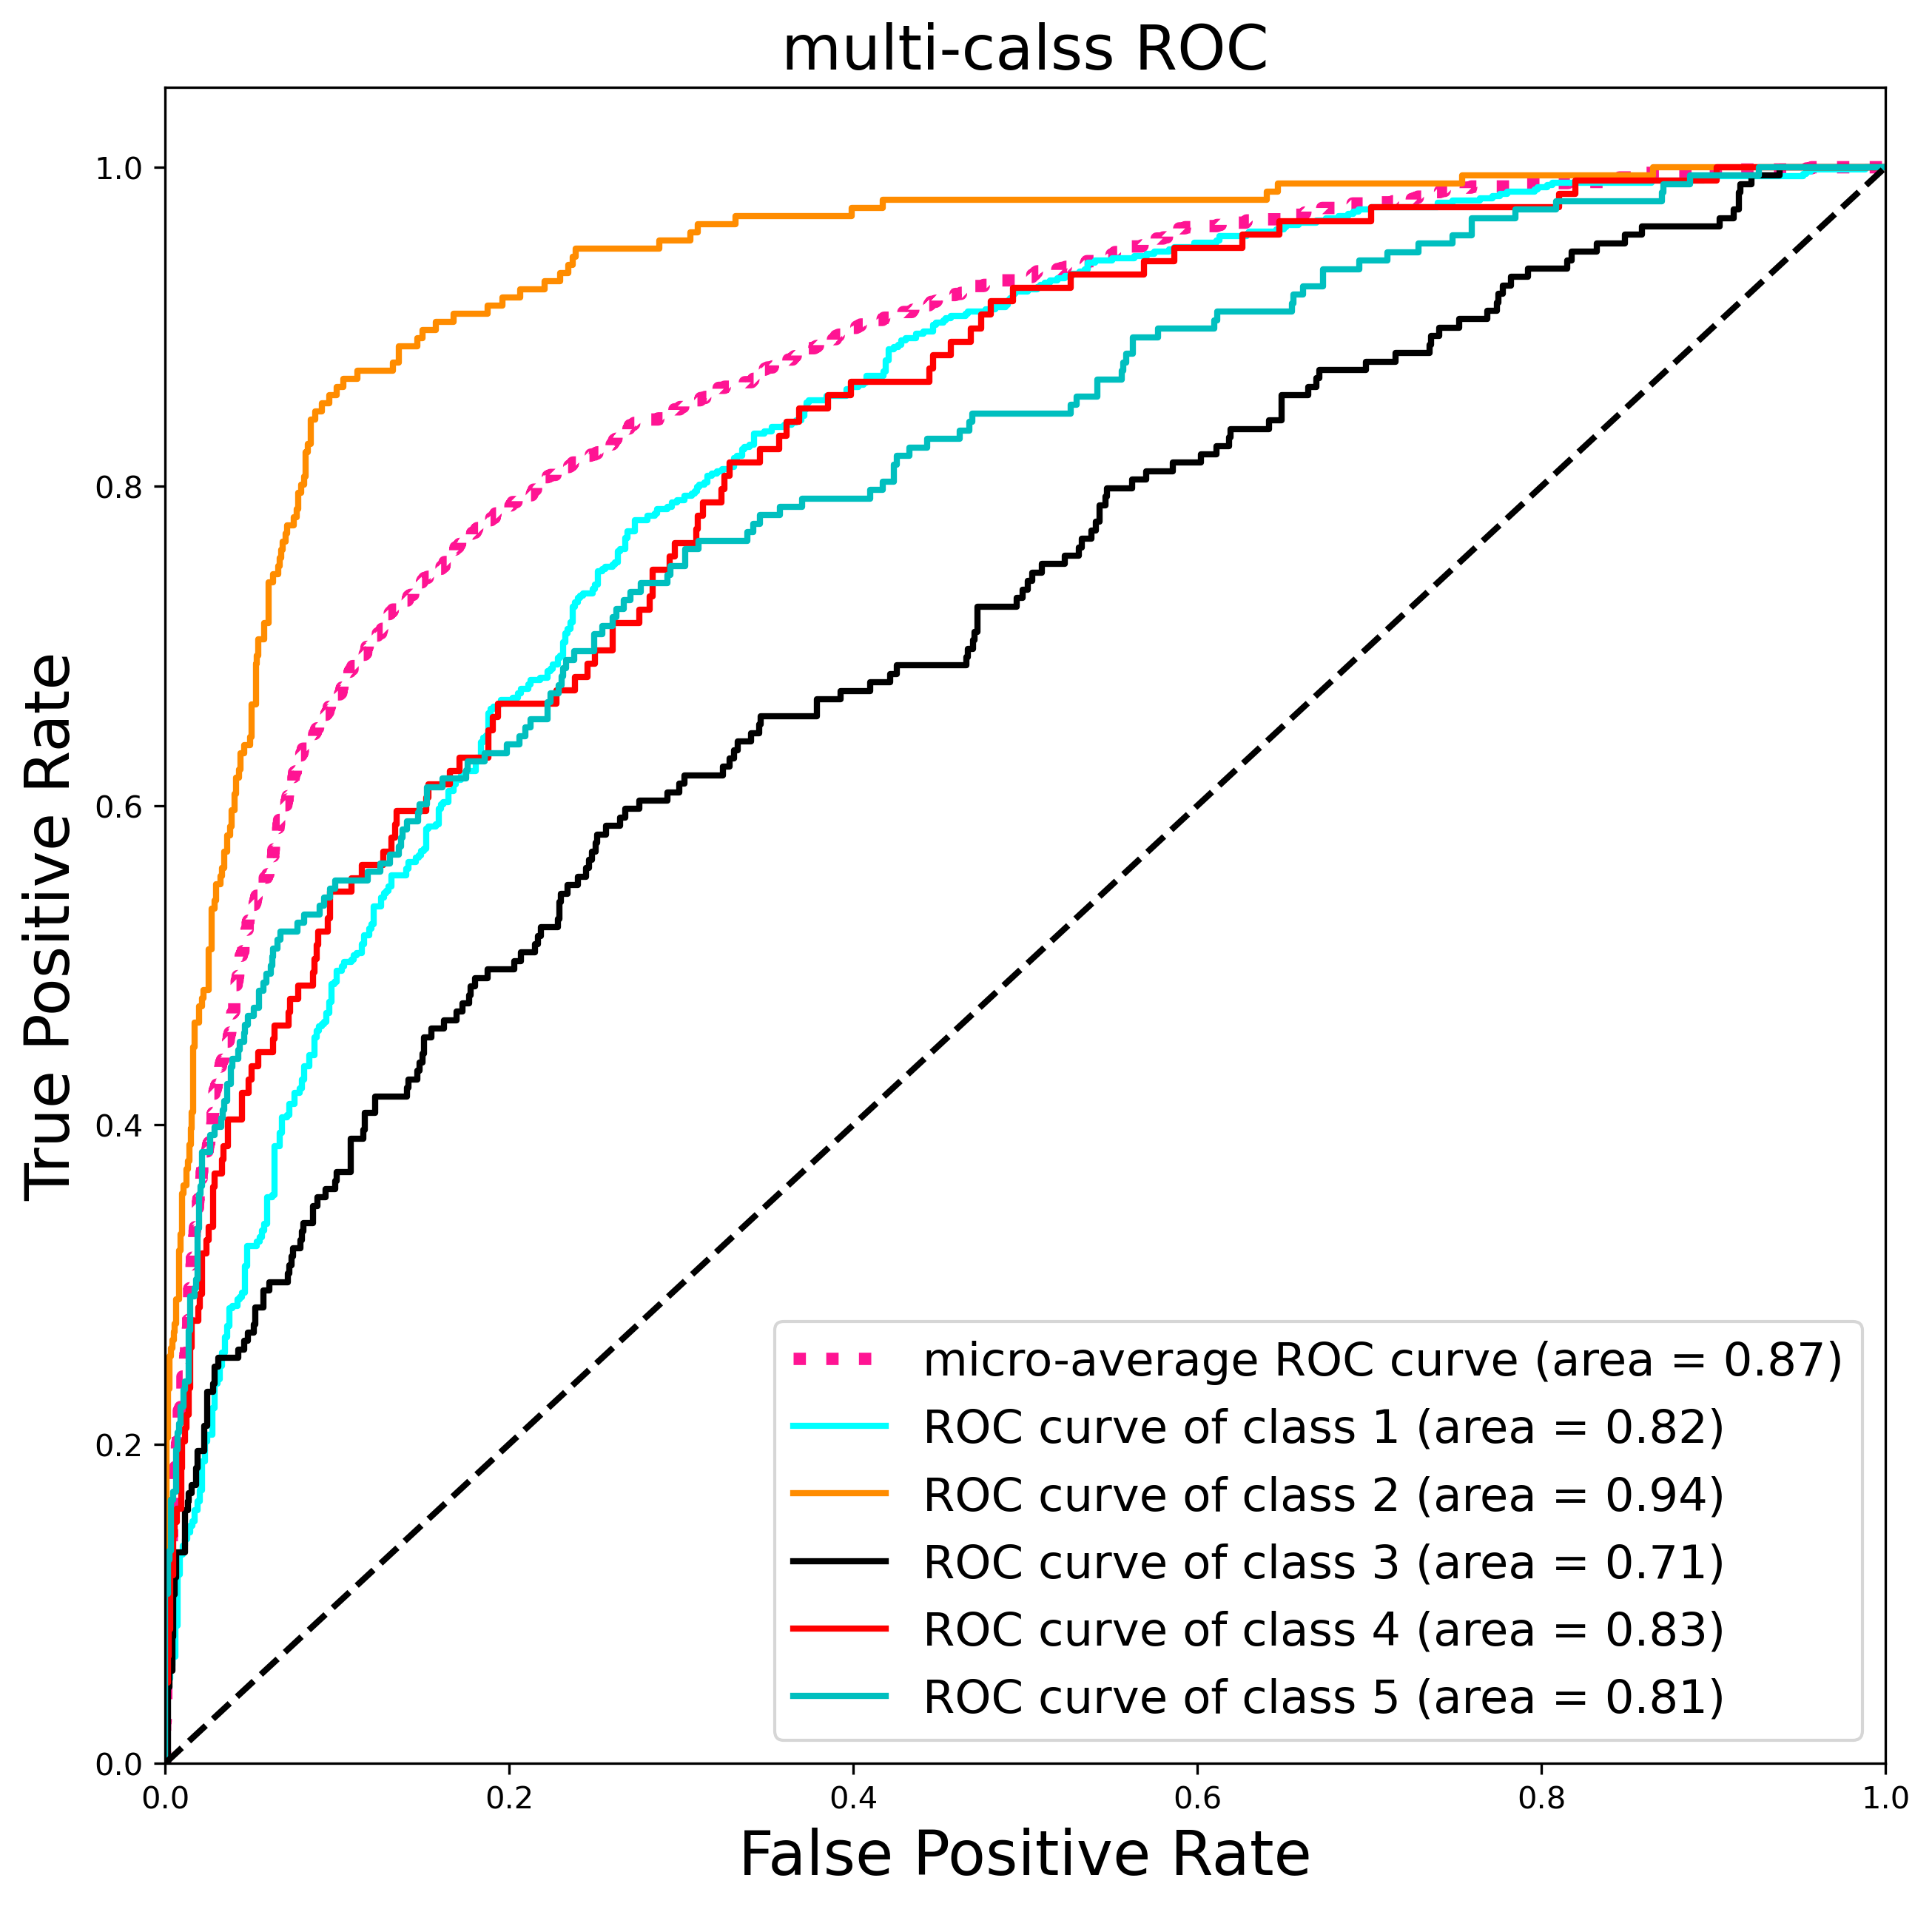

In [7]:
#ROC曲线 准确度最高
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
model.load_weights("./model/cpkt/cls_weight")
pre_test=model.predict(x_test)
y_true=y_test.numpy()
y_pre=pre_test
n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#################################################################################
lw=2
plt.figure(dpi=300, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'k',  'r', 'c'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('multi-calss ROC',fontsize=20)
plt.legend(loc="lower right",fontsize=15)
plt.savefig("filter_ROC_0.677.png",dpi=300,format='png')
plt.show()